In [1]:
##Programmed and tested by Madhosh Yagnik
##AI, Batch IV

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [3]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNetV2, ResNet50, VGG19
from tensorflow.keras.layers import AveragePooling2D
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Input
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.models import load_model
from sklearn.preprocessing import OneHotEncoder
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
import warnings
warnings.filterwarnings("ignore")
from imutils import paths
import matplotlib.pyplot as plt
import numpy as np
import argparse
import os
import cv2

In [4]:
path = '/content/drive/My Drive/maskclassifier/train/'
imagePaths = list(paths.list_images(path))
images = []
labels = []
for imagePath in imagePaths:
	label = imagePath.split(os.path.sep)[-2]
	image = load_img(imagePath, target_size=(224, 224))
	image = img_to_array(image)
	image = preprocess_input(image)
	images.append(image)
	labels.append(label)
images = np.array(images, dtype="float32")
labels = np.array(labels)

In [5]:
print(images.shape)
print(labels.shape)

(1376, 224, 224, 3)
(1376,)


In [6]:
np.unique(labels)

array(['with_mask', 'without_mask'], dtype='<U12')

In [7]:
encoder = LabelBinarizer()
labels = encoder.fit_transform(labels)
labels = to_categorical(labels)

In [8]:
X_train, X_test, y_train, y_test = train_test_split(images, labels,test_size=0.20, stratify=labels)

In [9]:
datagen = ImageDataGenerator(
	rotation_range=20,
	zoom_range=0.15,
	width_shift_range=0.2,
	height_shift_range=0.2,
	shear_range=0.15,
	horizontal_flip=True,
	fill_mode="nearest")

In [10]:
baseModel = MobileNetV2(weights="imagenet", include_top=False,
	input_tensor=Input(shape=(224, 224, 3)))
X = baseModel.output
X = AveragePooling2D(pool_size=(7, 7))(X)
X = Flatten()(X)
X = Dense(128, activation="relu")(X)
X = Dropout(0.5)(X)
X = Dense(2, activation="softmax")(X)
model = Model(inputs=baseModel.input, outputs=X)

9412608/9406464 [==============================] - 0s 0us/step


In [11]:
for layer in baseModel.layers:
	layer.trainable = False

In [12]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
Conv1_pad (ZeroPadding2D)       (None, 225, 225, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
Conv1 (Conv2D)                  (None, 112, 112, 32) 864         Conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_Conv1 (BatchNormalization)   (None, 112, 112, 32) 128         Conv1[0][0]                      
______________________________________________________________________________________________

In [13]:
batch_size = 128
epochs = 15
##here input is taken from the result of convolution, maxpooling on the input images.
##calculation time is actually reduced that way for large number of images.

In [14]:
optimizer = Adam(lr=1e-4, decay=1e-3)
model.compile(loss="binary_crossentropy", optimizer=optimizer, metrics=["accuracy"])
##metrices 'accuracy' will compare predicted results to those already known
##checks accuracy of predictions

In [15]:
##training the model and plotting a histogram for statistical analysis.
hist = model.fit(datagen.flow(X_train, y_train, batch_size=batch_size), 
            steps_per_epoch=len(X_train) // batch_size,
			validation_data=(X_test, y_test),
			validation_steps=len(X_test) // batch_size,
			epochs=epochs)

Epoch 1/15
8/8 [==============================] - 47s 6s/step - loss: 0.7282 - accuracy: 0.6492 - val_loss: 0.4047 - val_accuracy: 0.8587
Epoch 2/15
8/8 [==============================] - 46s 6s/step - loss: 0.4178 - accuracy: 0.7984 - val_loss: 0.2477 - val_accuracy: 0.9710
Epoch 3/15
8/8 [==============================] - 44s 5s/step - loss: 0.2872 - accuracy: 0.8920 - val_loss: 0.1576 - val_accuracy: 0.9783
Epoch 4/15
8/8 [==============================] - 43s 5s/step - loss: 0.2040 - accuracy: 0.9383 - val_loss: 0.1095 - val_accuracy: 0.9783
Epoch 5/15
8/8 [==============================] - 44s 5s/step - loss: 0.1414 - accuracy: 0.9588 - val_loss: 0.0808 - val_accuracy: 0.9891
Epoch 6/15
8/8 [==============================] - 43s 5s/step - loss: 0.1192 - accuracy: 0.9743 - val_loss: 0.0628 - val_accuracy: 0.9891
Epoch 7/15
8/8 [==============================] - 44s 5s/step - loss: 0.0975 - accuracy: 0.9763 - val_loss: 0.0510 - val_accuracy: 0.9891
Epoch 8/15
8/8 [==================

In [16]:
y_pred = model.predict(X_test, batch_size=batch_size)
y_pred = np.argmax(y_pred, axis=1)
print(classification_report(y_test.argmax(axis=1), y_pred, target_names=encoder.classes_))

              precision    recall  f1-score   support

   with_mask       0.99      1.00      1.00       138
without_mask       1.00      0.99      1.00       138

    accuracy                           1.00       276
   macro avg       1.00      1.00      1.00       276
weighted avg       1.00      1.00      1.00       276



In [17]:
model.save("model", save_format="h5")

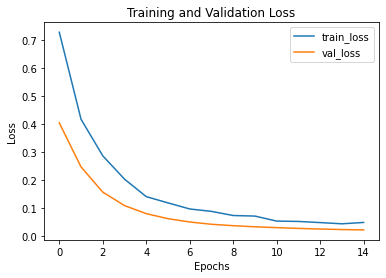

In [18]:
plt.plot(np.arange(0, epochs), hist.history["loss"], label="train_loss")
plt.plot(np.arange(0, epochs), hist.history["val_loss"], label="val_loss")
plt.title("Training and Validation Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend(loc="upper right")

In [19]:
prototxtPath = '/content/drive/My Drive/maskclassifier/face_detector/deploy.prototxt'
weightsPath = '/content/drive/My Drive/maskclassifier/face_detector/res10_300x300_ssd_iter_140000.caffemodel'
face_model = cv2.dnn.readNet(prototxtPath, weightsPath)
model = load_model("model")

In [21]:
image = cv2.imread('/content/drive/My Drive/maskclassifier/test/test2.jpg')
height, width = image.shape[:2]
blob = cv2.dnn.blobFromImage(image, 1.0, (300, 300), (104.0, 177.0, 123.0))
face_model.setInput(blob)
detections = face_model.forward()			

Number of person with mask : 2
Number of person without mask : 1


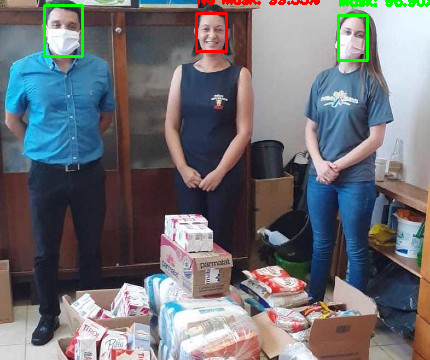

In [22]:
from google.colab.patches import cv2_imshow
threshold = 0.2
person_with_mask = 0;
person_without_mask = 0;
for i in range(0, detections.shape[2]):
	score = detections[0, 0, i, 2]
	if score > threshold:
		#coordinates of the bounding box
		box = detections[0, 0, i, 3:7] * np.array([width, height, width, height])
		X_start, Y_start, X_end, Y_end = box.astype("int")
		X_start, Y_start = (max(0, X_start), max(0, Y_start))
		X_end, Y_end = (min(width - 1, X_end), min(height - 1, Y_end))

		face = image[Y_start:Y_end, X_start:X_end]
		face = cv2.cvtColor(face, cv2.COLOR_BGR2RGB)		#Convert to rgb
		face = cv2.resize(face, (224, 224))					#resize
		face = img_to_array(face)							
		face = preprocess_input(face)
		face = np.expand_dims(face, axis=0)	
	
		mask, withoutMask = model.predict(face)[0]			#To predict mask or not on the face

		if mask > withoutMask:								#determining the label
			label = "Mask"
			person_with_mask += 1
		else: 
			label = "No Mask"
			person_without_mask += 1
			
		if label == "Mask":									#determine the color
			color = (0, 255, 0)
		else:
			color = (0, 0, 255)
		label = "{}: {:.2f}%".format(label, max(mask, withoutMask) * 100)		#label and probability
		cv2.putText(image, label, (X_start, Y_start - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.45, color, 2)
		cv2.rectangle(image, (X_start, Y_start), (X_end, Y_end), color, 2)
  
print("Number of person with mask : {}".format(person_with_mask))
print("Number of person without mask : {}".format(person_without_mask))
cv2_imshow(image)